# Modèle probabiliste à partir de la cartographie des indicateurs cliniques

In [1]:
!python -m pip install daft

In [133]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 147.2 MB 1.5 MB/s eta 0:00:011


In [159]:
import daft
import matplotlib as plt
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

### Modèle Bayésien : exemple de la dénutrition

Paramétrage du graph orienté

In [127]:
pgm = daft.PGM(grid_unit=4.0, node_unit=1.4)
asp = 2

f_color = {"ec": "#46a546"}
s_color = {"ec": "#f89406"}
c_color = {"ec": "#fb2e02"}

### Création des noeuds par categories : sondes, contextes, facteurs et conseils

In [128]:
pgm.add_node("lieu", r"lieu de résidence", 2, -0.5, fixed=True)


pgm.add_node("poids", r"perte de poids", 3, 6, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("CM", r"CM", 2, 4, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("IMC", r"IMC", 4, 5, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("event_1", r"création event course", 6, 4, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("event_2", r"création event repas", 9, 5, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("memos_1", r"consultation memo lié nourriture", 10, 4, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("memos_2", r"création memos liste de course", 8, 4, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("motricite", r"motricité", -1, 4, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("gout", r"perte du goût", 0, 4, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("pb_digestif", r"problèmes digestifs", 1, 6, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("mastic", r"difficultés mastication", 0.5, 5, aspect=asp, plot_params=s_color) #sonde
pgm.add_node("deglut", r"difficultés deglutition", 1.5, 5, aspect=asp, plot_params=s_color) #sonde




pgm.add_node("perte", r"perte de poids", 3, 3, aspect=asp, plot_params=f_color) #facteur
pgm.add_node("pb_physique", r"problème physique", 1, 3, aspect=asp, plot_params=f_color) #facteur
pgm.add_node("pb_neuro", r"problème neuropsychologique", 5, 3, aspect=asp, plot_params=f_color) #facteur
pgm.add_node("achat", r"achat alimentaire", 7, 3, aspect=asp, plot_params=f_color) #facteur
pgm.add_node("habitude", r"changement d'habitudes alimentaires", 9, 3, aspect=asp, plot_params=f_color) #facteur



pgm.add_node("conseil_1", r"et si vous déjeuniez avec X ?", 3, 1, aspect=asp, plot_params=c_color) #conseil
pgm.add_node("conseil_2", r"et si vous alliez faire des courses ?", 6, 1, aspect=asp, plot_params=c_color) #conseil

'conseil_2'

### Création des dépendances entre les noeuds


In [129]:
pgm.add_edge("achat", "memos_2")
pgm.add_edge("achat", "event_1")
pgm.add_edge("perte", "IMC")
pgm.add_edge("perte", "CM")
pgm.add_edge("perte", "poids")
pgm.add_edge("habitude", "event_2")
pgm.add_edge("perte", "conseil_1")
pgm.add_edge("pb_physique", "conseil_1")
pgm.add_edge("pb_neuro", "conseil_1")
pgm.add_edge("habitude", "conseil_1")
pgm.add_edge("achat", "conseil_1")
pgm.add_edge("achat", "conseil_2")
pgm.add_edge("habitude", "conseil_2")
pgm.add_edge("habitude", "memos_1")
pgm.add_edge("lieu", "conseil_1")
pgm.add_edge("pb_physique", "motricite")
pgm.add_edge("pb_physique", "gout")
pgm.add_edge("pb_physique", "pb_digestif")
pgm.add_edge("pb_physique", "mastic")
pgm.add_edge("pb_physique", "deglut")

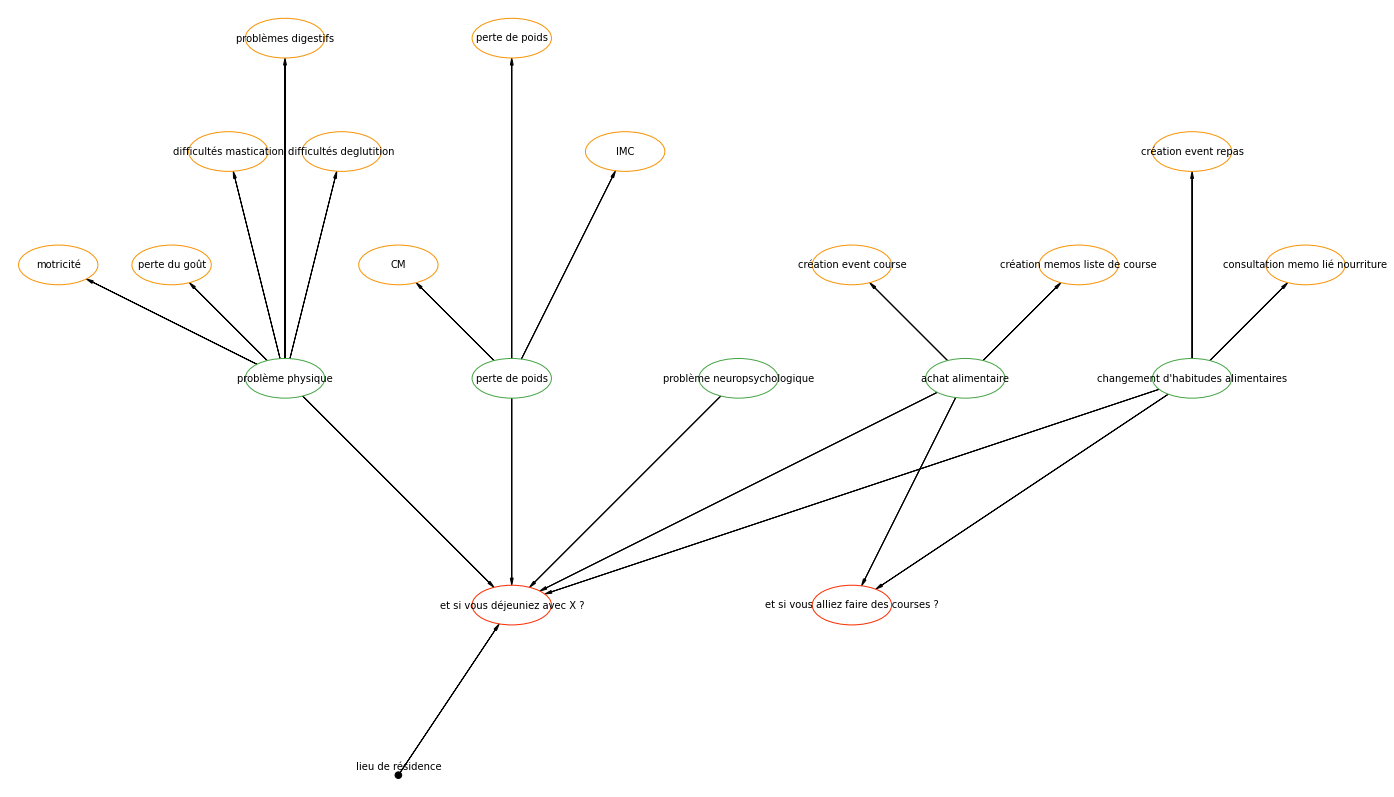

In [130]:
pgm.render()

En orange on a les sondes, qui sont des caractères observables permettant de mieux appréhender et définir les facteurs.

En vert, on a les facteurs.

En rouge, ce sont deux conseils binaires : "pertinenent" ou "non pertinent"

Le point noir correspond à un contexte : représente le contexte de la situation et influence uniquement les conseil.

### Modèle Bayésien : exemple du sommeil

Les facteurs sont les suivants :
- RN : Réveil Nocturne
- S : Qualité du sommeil

Les sondes sont les suivantes :
- OA : Ouverture de l'application
- AP : Activité physique

Le conseil :
- Conseil : "Pensez à demander à X comment est son sommeil !"

In [144]:
model = BayesianModel([("RN","Conseil"),("S", "Conseil"),("OA","RN"),("AP","RN")])

On va ensuite définir les CPD : les distributions des probabilités conditionnelles pour chaque noeud.

In [153]:
oa_cpd = TabularCPD(variable = 'OA', variable_card=2, values=[[0.9],[0.1]], state_names={'OA': ['Non', 'Oui']}) #valeurs choisies arbitrairement
ap_cpd = TabularCPD(variable = 'AP', variable_card=2, values=[[0.7],[0.3]], state_names={'AP': ['Non', 'Oui']})

s_cpd = TabularCPD(variable = 'S', variable_card=3, values=[[0.5],[0.3],[0.2]], state_names={'S': ['Bonne', 'Moyenne', 'Mauvaise']})

rn_cpd = TabularCPD(variable='RN', variable_card=3,
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['OA', 'AP'],
                  evidence_card=[2, 2], 
                    state_names={'RN': ['Faible', 'Moyen', 'Fort'],
                                   'OA': ['Non', 'Oui'],
                                   'AP': ['Non', 'Oui']})

conseil_cpd = TabularCPD(variable='Conseil', variable_card=2,
                         values=[[0.05, 0.3, 0.8,  0.6, 0.5, 0.6, 0.7, 0.8, 0.9],
                           [0.95, 0.7, 0.2, 0.4, 0.5, 0.4, 0.3, 0.2, 0.1]],
                  evidence=['S', 'RN'],
                  evidence_card=[3, 3], state_names={'Conseil':['Pertinent', 'Non pertinent'],
                      'RN': ['Faible', 'Moyen', 'Fort'],
                                   'S': ['Bonne', 'Moyenne', 'Mauvaise']})

model.add_cpds(oa_cpd, ap_cpd, s_cpd, rn_cpd, conseil_cpd)

model.check_model()

True

In [154]:
model.get_cpds()

[<TabularCPD representing P(OA:2) at 0x7feb26621220>,
 <TabularCPD representing P(AP:2) at 0x7feb26621070>,
 <TabularCPD representing P(S:3) at 0x7feb26621550>,
 <TabularCPD representing P(RN:3 | OA:2, AP:2) at 0x7feb26621dc0>,
 <TabularCPD representing P(Conseil:2 | S:3, RN:3) at 0x7feb26621310>]

#####  Tableau des probabilités conditionnelles au noeud des risques de réveils nocturnes

In [155]:
print(rn_cpd)

+------------+---------+---------+---------+---------+
| OA         | OA(Non) | OA(Non) | OA(Oui) | OA(Oui) |
+------------+---------+---------+---------+---------+
| AP         | AP(Non) | AP(Oui) | AP(Non) | AP(Oui) |
+------------+---------+---------+---------+---------+
| RN(Faible) | 0.3     | 0.05    | 0.9     | 0.5     |
+------------+---------+---------+---------+---------+
| RN(Moyen)  | 0.4     | 0.25    | 0.08    | 0.3     |
+------------+---------+---------+---------+---------+
| RN(Fort)   | 0.3     | 0.7     | 0.02    | 0.2     |
+------------+---------+---------+---------+---------+


#####  Tableau des probabilités conditionnelles au noeud du conseil

In [156]:
print(conseil_cpd)

+------------------------+-----+-------------+-------------+
| S                      | ... | S(Mauvaise) | S(Mauvaise) |
+------------------------+-----+-------------+-------------+
| RN                     | ... | RN(Moyen)   | RN(Fort)    |
+------------------------+-----+-------------+-------------+
| Conseil(Pertinent)     | ... | 0.8         | 0.9         |
+------------------------+-----+-------------+-------------+
| Conseil(Non pertinent) | ... | 0.2         | 0.1         |
+------------------------+-----+-------------+-------------+


On peut alors chercher les indépendances locales des noeuds définies plus haut.

In [158]:
model.local_independencies('Conseil')

(Conseil ⟂ AP, OA | RN, S)

Utilisation de la méthode d'inférence "Variable Elimination" des modèles graphiques

In [160]:
infer = VariableElimination(model)
g_dist = infer.query(['Conseil'])
print(g_dist)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+------------------------+----------------+
| Conseil                |   phi(Conseil) |
+========================+================+
| Conseil(Pertinent)     |         0.5434 |
+------------------------+----------------+
| Conseil(Non pertinent) |         0.4566 |
+------------------------+----------------+


In [162]:
print(infer.query(['Conseil'], evidence={'RN': 'Faible', 'S': 'Bonne'}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------------+----------------+
| Conseil                |   phi(Conseil) |
+========================+================+
| Conseil(Pertinent)     |         0.0500 |
+------------------------+----------------+
| Conseil(Non pertinent) |         0.9500 |
+------------------------+----------------+


Si le risque est de reveil nocturne est faible et que le sommeil est bon, il n'est pas pertinent (à 95 %) de conseiller à l'aidant d'envoyer à l'aidé des recommandations sur le sommeil.